In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

data = pd.read_csv("C:/Users/Emirhan/Desktop/verimaden/apartments_for_rent_classified_100K.csv", delimiter=';', encoding='ISO-8859-1')




In [45]:
data.head()


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1.0,1.0,USD,No,Thumbnail,...,"$2,195",Monthly,542,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1577360355
1,5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3.0,USD,No,Thumbnail,...,"$1,250",Monthly,1500,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1577360340
2,5668639686,housing/rent/apartment,Three BR 3101 Morningside Drive,This unit is located at 3101 Morningside Drive...,NaN,2.0,3.0,USD,No,Thumbnail,...,"$1,395",Monthly,1650,3101 Morningside Dr,Raleigh,NC,35.8230,-78.6438,RentLingo,1577360332
3,5668639659,housing/rent/apartment,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacavi...",NaN,1.0,2.0,USD,No,Thumbnail,...,"$1,600",Monthly,820,209 Aegean Way,Vacaville,CA,38.3622,-121.9712,RentLingo,1577360330
4,5668639374,housing/rent/apartment,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Alb...",NaN,1.0,1.0,USD,No,Thumbnail,...,$975,Monthly,624,4805 Marquette NE,Albuquerque,NM,35.1038,-106.6110,RentLingo,1577360308


In [46]:
data.columns

Index(['id', 'category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms',
       'currency', 'fee', 'has_photo', 'pets_allowed', 'price',
       'price_display', 'price_type', 'square_feet', 'address', 'cityname',
       'state', 'latitude', 'longitude', 'source', 'time'],
      dtype='object')

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99492 non-null  int64  
 1   category       99492 non-null  object 
 2   title          99492 non-null  object 
 3   body           99492 non-null  object 
 4   amenities      83448 non-null  object 
 5   bathrooms      99429 non-null  float64
 6   bedrooms       99368 non-null  float64
 7   currency       99492 non-null  object 
 8   fee            99492 non-null  object 
 9   has_photo      99492 non-null  object 
 10  pets_allowed   44138 non-null  object 
 11  price          99491 non-null  float64
 12  price_display  99491 non-null  object 
 13  price_type     99492 non-null  object 
 14  square_feet    99492 non-null  int64  
 15  address        7943 non-null   object 
 16  cityname       99190 non-null  object 
 17  state          99190 non-null  object 
 18  latitu

In [48]:
data.shape

(99492, 22)

## Aykırı değerleri filtrele

In [49]:
def filter_outliers_by_city(df):
    filtered_data = pd.DataFrame()
    
    for city in df['cityname'].unique():
        city_data = df[df['cityname'] == city]
        Q1 = city_data['price'].quantile(0.25)
        Q3 = city_data['price'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        filtered_city_data = city_data[(city_data['price'] >= lower_bound) & (city_data['price'] <= upper_bound)]
        filtered_data = pd.concat([filtered_data, filtered_city_data])
    
    return filtered_data


data = filter_outliers_by_city(data)


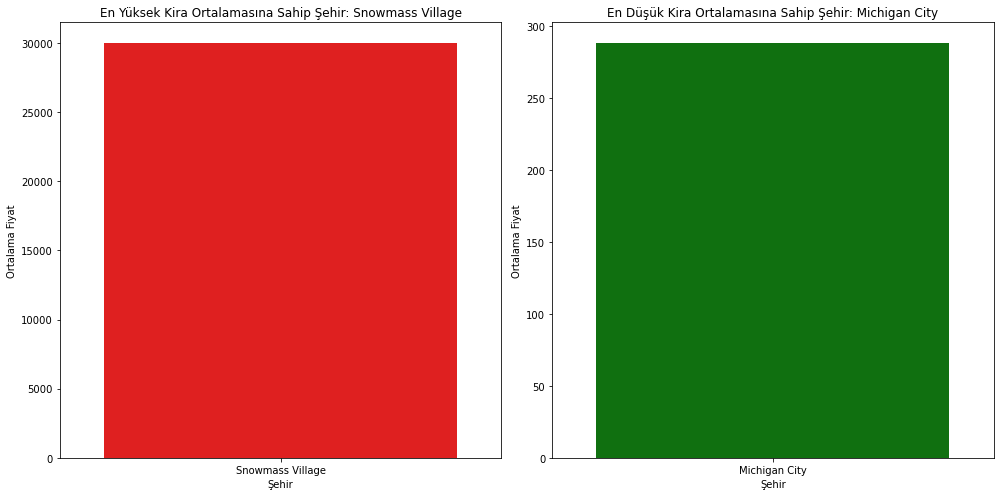

In [50]:
# Şehir bazında kira ortalamalarını hesapla
city_mean_prices = data.groupby('cityname')['price'].mean()

# NaN değerleri temizle
city_mean_prices = city_mean_prices.dropna()

# En yüksek ve en düşük kira ortalamasına sahip şehirler
highest_mean_city = city_mean_prices.idxmax()
lowest_mean_city = city_mean_prices.idxmin()

# En yüksek ve en düşük kira ortalamasına sahip şehirleri gösteren grafik
plt.figure(figsize=(14, 7))

# Yan yana çubuk grafikler
plt.subplot(1, 2, 1)
sns.barplot(x=[highest_mean_city], y=[city_mean_prices[highest_mean_city]], color='red')
plt.title(f'En Yüksek Kira Ortalamasına Sahip Şehir: {highest_mean_city}')
plt.xlabel('Şehir')
plt.ylabel('Ortalama Fiyat')

plt.subplot(1, 2, 2)
sns.barplot(x=[lowest_mean_city], y=[city_mean_prices[lowest_mean_city]], color='green')
plt.title(f'En Düşük Kira Ortalamasına Sahip Şehir: {lowest_mean_city}')
plt.xlabel('Şehir')
plt.ylabel('Ortalama Fiyat')

plt.tight_layout()
plt.show()

## Fiyat Aralıklarını Belirleme

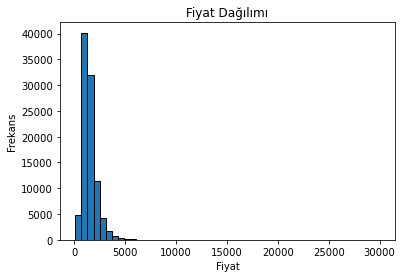

In [51]:
plt.hist(data['price'], bins=50, edgecolor='k')
plt.xlabel('Fiyat')
plt.ylabel('Frekans')
plt.title('Fiyat Dağılımı')
plt.show()

In [52]:
print("Ortalama Fiyat:", data['price'].mean())
print("Medyan Fiyat:", data['price'].median())
print("1. Çeyrek:", data['price'].quantile(0.25))
print("3. Çeyrek:", data['price'].quantile(0.75))
print("Standart Sapma:", data['price'].std())

Ortalama Fiyat: 1472.4219768355133
Medyan Fiyat: 1333.0
1. Çeyrek: 1000.0
3. Çeyrek: 1745.0
Standart Sapma: 697.5730070061056


In [53]:
# Şehir bazında fiyat aralıklarını belirle ve kategorilere ayır
def categorize_prices(df):
    labels = ['Düşük', 'Orta', 'Yüksek', 'Çok Yüksek']
    price_categories = pd.Series([None] * len(df), index=df.index)  # Boş bir seri oluştur
    bins_dict = {}  # Şehirlerin bin aralıklarını saklamak için
    for city in df['cityname'].unique():
        city_data = df[df['cityname'] == city]
        bins = [city_data['price'].min(), city_data['price'].quantile(0.25), city_data['price'].quantile(0.50), city_data['price'].quantile(0.75), city_data['price'].max()]
        bins = np.unique(bins)  # Benzersiz binler oluştur
        if len(bins) == 1:  # Tek benzersiz bin varsa
            bins = [bins[0], bins[0] + 1]  # İki benzersiz bin oluştur
        elif len(bins) < 4:
            bins = np.append(bins, [bins[-1] + i for i in range(1, 5 - len(bins))])  # Eksik binleri ekle
        bins[-1] = bins[-1] + 1  # Son bini biraz artır
        city_categories = pd.cut(city_data['price'], bins=bins, labels=labels[:len(bins) - 1], include_lowest=True)
        price_categories.update(city_categories)  # Fiyat kategorilerini güncelle
        bins_dict[city] = bins  # Bin aralıklarını kaydet
    df['price_category'] = price_categories
    return df, bins_dict

data, bins_dict = categorize_prices(data)


In [54]:
features_to_use = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'square_feet', 'has_photo', 'pets_allowed','cityname','price']

X = data[features_to_use]
y = data['price_category']

In [55]:
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (95491, 9)
y shape : (95491,)


In [56]:
X[:5]

,bathrooms,bedrooms,latitude,longitude,square_feet,has_photo,pets_allowed,cityname,price
0,1.0,1.0,33.8520,-118.3759,542,Thumbnail,Cats,Redondo Beach,2195.0
451,1.0,2.0,33.8520,-118.3759,500,Thumbnail,Cats,Redondo Beach,1995.0
909,1.0,1.0,33.8520,-118.3759,550,Thumbnail,Cats,Redondo Beach,1895.0
1321,2.0,2.0,33.8520,-118.3759,905,Thumbnail,"Cats,Dogs",Redondo Beach,2859.0
2106,1.0,2.0,33.8517,-118.3978,325,Thumbnail,Cats,Redondo Beach,1995.0


In [57]:
y[:10]

0          Orta
451       Düşük
909       Düşük
1321     Yüksek
2106      Düşük
3210     Yüksek
6070     Yüksek
6703       Orta
7419     Yüksek
10283      Orta
Name: price_category, dtype: object

## Label Encoding

In [58]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [59]:
for column in ['bedrooms', 'has_photo', 'pets_allowed','cityname']:
    X[column] = label_encoder.fit_transform(X[column])

In [60]:
X.fillna(X.mean(), inplace=True)

## Find NaN values

In [61]:
X.isna().any()

bathrooms       False
bedrooms        False
latitude        False
longitude       False
square_feet     False
has_photo       False
pets_allowed    False
cityname        False
price           False
dtype: bool

In [62]:
columnsWithNullValues = X.isna().any()
columnsWithNullValues = columnsWithNullValues[columnsWithNullValues == True]
columnsWithNullValues

Series([], dtype: bool)

In [63]:
# Belirtilen sütunları seçin
selected_columns = ['bathrooms', 'bedrooms','latitude', 'longitude']
selected_data = X[selected_columns]

# NaN veya null değerleri sütun ortalaması ile doldurdum.
selected_data.fillna(selected_data.mean(), inplace=True)

# Değişiklikleri X DataFrame'ine uygulayın
X[selected_columns] = selected_data


## Normalizasyon

In [64]:
X

,bathrooms,bedrooms,latitude,longitude,square_feet,has_photo,pets_allowed,cityname,price
0,1.0,1,33.8520,-118.3759,542,1,0,2202,2195.0
451,1.0,2,33.8520,-118.3759,500,1,0,2202,1995.0
909,1.0,1,33.8520,-118.3759,550,1,0,2202,1895.0
1321,2.0,2,33.8520,-118.3759,905,1,1,2202,2859.0
2106,1.0,2,33.8517,-118.3978,325,1,0,2202,1995.0
...,...,...,...,...,...,...,...,...,...
99338,2.5,3,34.2853,-118.4988,1580,2,5,1003,3295.0
99352,1.0,2,45.1219,-93.4572,1058,2,5,1969,1280.0
99361,2.0,2,42.0556,-76.0246,1000,2,5,2730,1500.0
99385,1.0,2,45.2381,-93.6555,884,2,1,20,995.0


In [65]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=features_to_use)
X

,bathrooms,bedrooms,latitude,longitude,square_feet,has_photo,pets_allowed,cityname,price
0,0.000000,0.125,0.315475,0.452516,0.011053,0.5,0.0,0.739422,0.070067
1,0.000000,0.250,0.315475,0.452516,0.010000,0.5,0.0,0.739422,0.063378
2,0.000000,0.125,0.315475,0.452516,0.011253,0.5,0.0,0.739422,0.060033
3,0.133333,0.250,0.315475,0.452516,0.020151,0.5,0.2,0.739422,0.092274
4,0.000000,0.250,0.315468,0.452275,0.005614,0.5,0.0,0.739422,0.063378
...,...,...,...,...,...,...,...,...,...
95486,0.200000,0.375,0.325048,0.451160,0.037069,1.0,1.0,0.336803,0.106856
95487,0.000000,0.250,0.564482,0.727584,0.023986,1.0,1.0,0.661182,0.039465
95488,0.133333,0.250,0.496732,0.920016,0.022532,1.0,1.0,0.916723,0.046823
95489,0.000000,0.250,0.567049,0.725395,0.019625,1.0,0.2,0.006716,0.029933


## Korelasyon matrisi

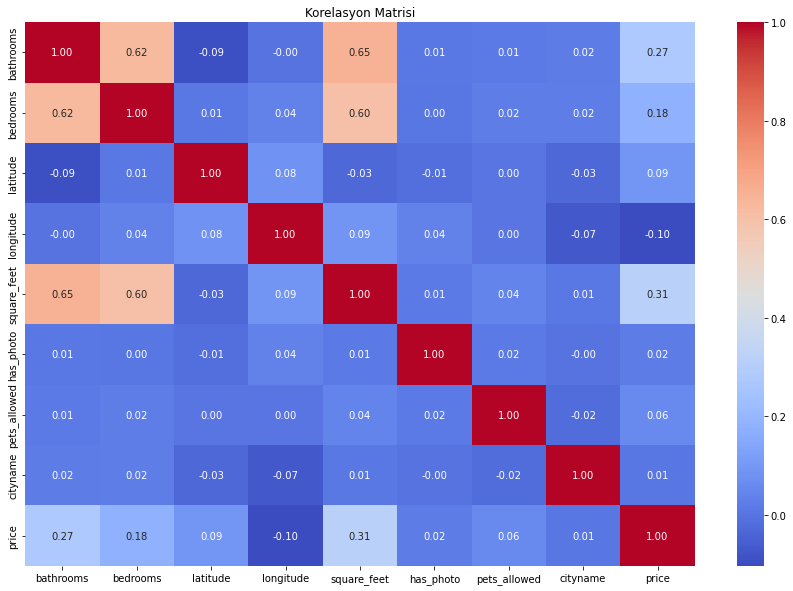

In [66]:
corr_matrisi = X.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrisi, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasyon Matrisi')
plt.show()


# KNN

In [67]:
# KNN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Doğruluk değeri:", accuracy_knn)

KNN Doğruluk değeri: 0.7045918634483481


# Decision Tree

In [68]:
# Veri setinizi X ve Y değişkenlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree modelini oluşturun ve eğitin
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Test verilerini kullanarak tahmin yapın
y_pred = decision_tree_model.predict(X_test)

# Doğruluk değerini hesaplayın ve ekrana bastırın
accuracy_dt = accuracy_score(y_test, y_pred)
print("Doğruluk değeri:", accuracy_dt)

Doğruluk değeri: 0.836902455625949


# Naive Bayes

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes modelini oluşturun ve eğitin
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Test verilerini kullanarak tahmin yapın
y_pred = nb_model.predict(X_test)

# Doğruluk değerini hesaplayın ve ekrana bastırın
accuracy_nb = accuracy_score(y_test, y_pred)
print("Doğruluk değeri:", accuracy_nb)

Doğruluk değeri: 0.4611236190376459


# Lojistik Regresyon

In [70]:
from sklearn.linear_model import LogisticRegression


# Veri setinizi X ve Y değişkenlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lojistik Regresyon modelini oluşturun ve eğitin
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Test verilerini kullanarak tahmin yapın
y_pred = logreg_model.predict(X_test)

# Doğruluk değerini hesaplayın ve ekrana bastırın
accuracy_lr = accuracy_score(y_test, y_pred)
print("Doğruluk değeri:", accuracy_lr)


Doğruluk değeri: 0.45991936750615214


# Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest modelini oluşturun ve eğitin
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Test verilerini kullanarak tahmin yapın
y_pred = rf_model.predict(X_test)

# Doğruluk değerini hesaplayın ve ekrana bastırın
accuracy_rf = accuracy_score(y_test, y_pred)
print("Doğruluk değeri:", accuracy_rf)

Doğruluk değeri: 0.86397193570344


# Model performansını kıyaslayan bar grafiği

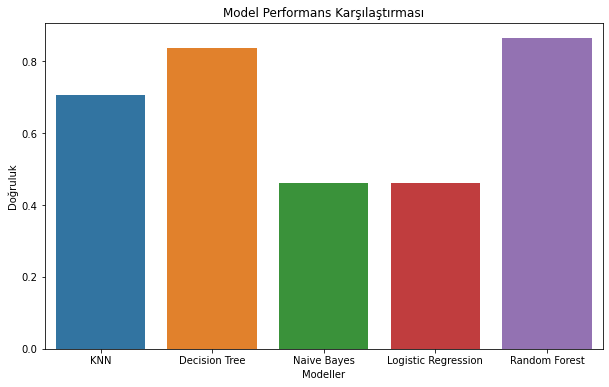

In [72]:

model_names = ["KNN", "Decision Tree", "Naive Bayes", "Logistic Regression", "Random Forest"]
accuracies = [accuracy_knn, accuracy_dt, accuracy_nb,accuracy_lr,accuracy_rf]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies)
plt.xlabel('Modeller')
plt.ylabel('Doğruluk')
plt.title('Model Performans Karşılaştırması')
plt.show()